# Generate flux bar plot from Mass Balance file (.dat)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import glob
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
from scipy import interpolate
import os
import re
from natsort import natsorted, ns, natsort_keygen
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def batch_time_to_delta(origin, x, time_format):
    y = []
    for ix in x:
        temp_y = abs(datetime.strptime(
            ix, time_format) - origin).total_seconds()
        y.append(temp_y)
    y = np.asarray(y)
    return(y)

def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    y = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in y]
    return(y)

## I/O files

In [3]:
# inputs
data_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/data/"
fname_usgs_gage = data_dir + "USGS_flow_gh_12472800.csv"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"
fname_river_middle = data_dir + "river_middle.csv"
fname_river_north = data_dir + "river_north.csv"
fname_river_south = data_dir + "river_south.csv"

model_dir = "/Users/shua784/Paraview/HFR/HFR_model_200x200x2_1w_bc/"
fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran*.h5"
fname_mass_dat = model_dir + "*mas.dat"

model_dir_2 = "/Users/shua784/Paraview/HFR/HFR_model_200x200x2_6h_bc/"
fname_mass_dat_2 = model_dir_2 + "*mas.dat"

fname_river_bc = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Inputs/river_bc/bc_6h_smooth_032807/"
fname_river_bc_1w = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Inputs/river_bc/bc_1w_smooth_032807/"
# outputs
out_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Outputs/HFR_model_200x200x2_1w_bc/"
out_dir_2 = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Outputs/HFR_model_200x200x2_6h_bc/"

fig_finger_flux = out_dir + "mass_balance/finger_flux.png"
fig_net_exchange_bar = out_dir + "mass_balance/net_exchange.png"
fname_net_exchange_txt = out_dir + "mass_balance/net_exchange.txt"
fig_flux_snapshot = out_dir + "mass_balance/"
fig_block_middle_flux_snapshot = out_dir + "flux_block_middle/"
fig_block_north_flux_snapshot = out_dir + "flux_block_north/"
fig_block_south_flux_snapshot = out_dir + "flux_block_south/"
fig_finger_flux_1w = out_dir + "finger_flux_1w.png"
fig_finger_flux_6h = out_dir_2 + "finger_flux_6h.png"
fig_finger_flux_diff = out_dir_2 + "finger_flux/"

In [4]:
date_origin = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")
model_origin = np.genfromtxt(
    fname_model_origin, delimiter=" ", skip_header=1)
material_file = h5.File(fname_material_h5, "r")

In [7]:
# middle block
block_middle_coord = np.genfromtxt(fname_river_middle, delimiter=",", skip_header=1)
block_middle_x = [(np.min(block_middle_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_middle_coord[:, 1]) - model_origin[0]) / 1000]

block_middle_y = [(np.min(block_middle_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_middle_coord[:, 2]) - model_origin[1]) / 1000]
# north block
block_north_coord = np.genfromtxt(fname_river_north, delimiter=",", skip_header=1)
block_north_x = [(np.min(block_north_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_north_coord[:, 1]) - model_origin[0]) / 1000]

block_north_y = [(np.min(block_north_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_north_coord[:, 2]) - model_origin[1]) / 1000]
# south block
block_south_coord = np.genfromtxt(fname_river_south, delimiter=",", skip_header=1)
block_south_x = [(np.min(block_south_coord[:, 1]) - model_origin[0]) / 1000,
           (np.max(block_south_coord[:, 1]) - model_origin[0]) / 1000]

block_south_y = [(np.min(block_south_coord[:, 2]) - model_origin[1]) / 1000,
           (np.max(block_south_coord[:, 2]) - model_origin[1]) / 1000]

In [8]:
discharge_file = open(fname_usgs_gage, "r")
discharge_data = discharge_file.readlines()
# print(discharge_data)

discharge_data = [x.replace('"', "") for x in discharge_data]
discharge_data = [x.split(",") for x in discharge_data[1:]]
discharge_data = [list(filter(None, x)) for x in discharge_data]
discharge_data = np.asarray(discharge_data)
discharge_time = [datetime.strptime(x, "%Y-%m-%d")
                  for x in discharge_data[:, 3]]
discharge_value = discharge_data[:, 4]  # .astype(float)

In [11]:
# read model dimensions
all_h5 = glob.glob(fname_pflotran_h5)
all_h5 = np.sort(all_h5)

input_h5 = h5.File(all_h5[0], "r")
x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
input_h5.close()

# x_grids = np.arange(0, 60001, 100)
# y_grids = np.arange(0, 60001, 100)
# z_grids = np.arange(0, 201, 5)

dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

west_area = dy[0] * dz[0]
east_area = dy[0] * dz[0]
south_area = dx[0] * dz[0]
north_area = dx[0] * dz[0]
top_area = dx[0] * dy[0]
bottom_area = dx[0] * dy[0]

In [12]:
# read river section information
mass1_sections = [s for s, s in enumerate(
    list(material_file["Regions"].keys())) if "Mass1" in s]
group_order = np.argsort(np.asarray(
    [x[6:] for x in mass1_sections]).astype(float))
mass1_sections = [mass1_sections[i] for i in group_order]
nsection = len(mass1_sections)
section_area = []
for isection in mass1_sections:
    faces = list(material_file["Regions"][isection]['Face Ids'])
    iarea = faces.count(1) * west_area + faces.count(2) * east_area + \
        faces.count(3) * south_area + faces.count(4) * north_area + \
        faces.count(5) * bottom_area + faces.count(6) * bottom_area
    section_area.append(iarea)
section_area = np.asarray(section_area)


In [13]:
# read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)

section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
# subtract last mass1 location to get length for each segment
mass1_length = section_coord[:, 4] - section_coord[-1, 4]


In [14]:
# add three lines to contour indicating mass1 location
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000
line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

In [15]:
# read mass balance data
mass_file = open(glob.glob(fname_mass_dat)[0], "r")
mass_data = mass_file.readlines()
mass_header = mass_data[0].replace('"', '').split(",")
mass_header = list(filter(None, mass_header))
mass_data = [x.split(" ") for x in mass_data[1:]]
mass_data = [list(filter(None, x)) for x in mass_data]
mass_data = np.asarray(mass_data).astype(float)

In [16]:
print(mass_header[0:20])
print(mass_data[0])

[' Time [h]', 'dt_flow [h]', 'dt_tran [h]', 'Global Water Mass [kg]', 'Global Tracer [mol]', 'Global Tracer_Age [mol]', 'River_40 Water Mass [kg]', 'River_40 Water Mass [kg/h]', 'River_40 Tracer [mol]', 'River_40 Tracer_Age [mol]', 'River_40 Tracer [mol/h]', 'River_40 Tracer_Age [mol/h]', 'River_41 Water Mass [kg]', 'River_41 Water Mass [kg/h]', 'River_41 Tracer [mol]', 'River_41 Tracer_Age [mol]', 'River_41 Tracer [mol/h]', 'River_41 Tracer_Age [mol/h]', 'River_42 Water Mass [kg]', 'River_42 Water Mass [kg/h]']
[ 3.24000000e+04  1.45312500e+00  1.45312500e+00 ... -3.51599024e+15
 -3.64919824e+05 -8.06420568e+12]


In [17]:
# find columns of desired mass1 colmns
# e.g River_40 Water Mass [kg]
mass_index = [i for i, s in enumerate(mass_header) if (
    "River" in s and "Water" in s and "kg]" in s)]
# e.g River_40 Water Mass [kg/h]
flux_index = [i for i, s in enumerate(mass_header) if (
    "River" in s and "Water" in s and "kg/h" in s)]


In [18]:
# get total river mass/flux across the river bed
total_mass = np.sum(mass_data[:, mass_index], axis=1).flatten()
total_flux = np.sum(mass_data[:, flux_index], axis=1).flatten()

In [19]:
# shift mass when restart happened, new starting mass would shift to zero
diff_total_mass = abs(np.diff(total_mass))
restart_index = np.arange(len(diff_total_mass))[diff_total_mass > 2e10]

for i_restart_index in restart_index:
    total_mass[(i_restart_index + 1):len(total_mass)] = total_mass[(
        i_restart_index + 1):len(total_mass)] + total_mass[restart_index]

# plot river stage


In [69]:
start_time = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")

In [5]:
datum_files = glob.glob(fname_river_bc + "Datum*.txt")

# int(re.findall(r'\d+', datum_files[0])[-1])
datum_files = natsorted(datum_files) # sort files naturally, i.e. 1, 2, 11, 22, ...


In [6]:
river_north_datum = pd.read_table(datum_files[0], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
river_middle_datum = pd.read_table(datum_files[(len(datum_files)-1)//2], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
river_south_datum = pd.read_table(datum_files[-1], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])

river_north_datum.time = batch_delta_to_time(date_origin, river_north_datum.time, "%Y-%m-%d %H:%M:%S", "seconds")
river_middle_datum.time = batch_delta_to_time(date_origin, river_middle_datum.time, "%Y-%m-%d %H:%M:%S", "seconds")
river_south_datum.time = batch_delta_to_time(date_origin, river_south_datum.time, "%Y-%m-%d %H:%M:%S", "seconds")
# datum_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in datum_time]

TypeError: unsupported type for timedelta seconds component: numpy.int64

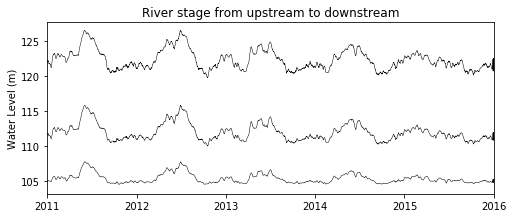

In [173]:
fig, ax1 = plt.subplots(1, 1)

river_north_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)
river_middle_datum.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
river_south_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)

ax1.set_ylabel('Water Level (m)')
ax1.set_xlabel('')
ax1.set_title('River stage from upstream to downstream')
# ax1.set_aspect("equal", "datalim")
plt.xticks(time_ticks, rotation=0, horizontalalignment = "center")
# ax1.set_xticks(time_ticks)
# ax1.set_tick_params(horizontalalignment='center')
# ax1.set_ylim([0, 7.3e1])
ax1.set_xlim([time_ticks[0], time_ticks[-1]])

# ax1.legend(handles=legend_elements, loc='best')
fig.set_size_inches(8, 3.5)

In [174]:
fname = fig_finger_flux_diff + 'river_stage_1w.png'
fig.savefig(fname, dpi=300)
plt.close(fig)

plot smoothed river stage

In [152]:
datum_files = glob.glob(fname_river_bc_1w + "Datum*.txt")

# int(re.findall(r'\d+', datum_files[0])[-1])
datum_files = natsorted(datum_files) # sort files naturally, i.e. 1, 2, 11, 22, ...


In [153]:
river_north_datum = pd.read_table(datum_files[0], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
river_middle_datum = pd.read_table(datum_files[(len(datum_files)-1)//2], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])
river_south_datum = pd.read_table(datum_files[-1], sep=' ', header=None, names=['time', 'x', 'y', 'wl'])

river_north_datum.time = batch_delta_to_time(date_origin, river_north_datum.time, "%Y-%m-%d %H:%M:%S", "seconds")
river_middle_datum.time = batch_delta_to_time(date_origin, river_middle_datum.time, "%Y-%m-%d %H:%M:%S", "seconds")
river_south_datum.time = batch_delta_to_time(date_origin, river_south_datum.time, "%Y-%m-%d %H:%M:%S", "seconds")
# datum_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in datum_time]

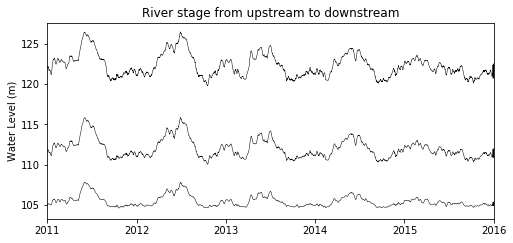

In [154]:
fig, ax1 = plt.subplots(1, 1)

river_north_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)
river_middle_datum.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
river_south_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)

ax1.set_ylabel('Water Level (m)')
ax1.set_xlabel('')
ax1.set_title('River stage from upstream to downstream')
# ax1.set_aspect("equal", "datalim")
plt.xticks(time_ticks, rotation=0, horizontalalignment = "center")
# ax1.set_xticks(time_ticks)
# ax1.set_tick_params(horizontalalignment='center')
# ax1.set_ylim([0, 7.3e1])
ax1.set_xlim([time_ticks[0], time_ticks[-1]])

# ax1.legend(handles=legend_elements, loc='best')
fig.set_size_inches(8, 4)

# plot finger flux

## plot finger flux - 1w bc

In [85]:
# plot fingerprint plots
simu_time = mass_data[:, 0]
real_time = batch_delta_to_time(
    date_origin, simu_time, "%Y-%m-%d %H:%M:%S", "hours")
real_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_time]
plot_time = [
    "2011-01-01 00:00:00",
    "2016-01-01 00:00:00"]
plot_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in plot_time]
time_ticks = [
    "2011-01-01 00:00:00",
    "2012-01-01 00:00:00",
    "2013-01-01 00:00:00",
    "2014-01-01 00:00:00",
    "2015-01-01 00:00:00",
    "2016-01-01 00:00:00"]
time_ticks = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in time_ticks]

In [ ]:
flux_array = mass_data[:, flux_index]
flux_array = np.asarray(flux_array) / 1000 * 24
for itime in range(len(real_time)):
    flux_array[itime, :] = flux_array[itime, :] / section_area

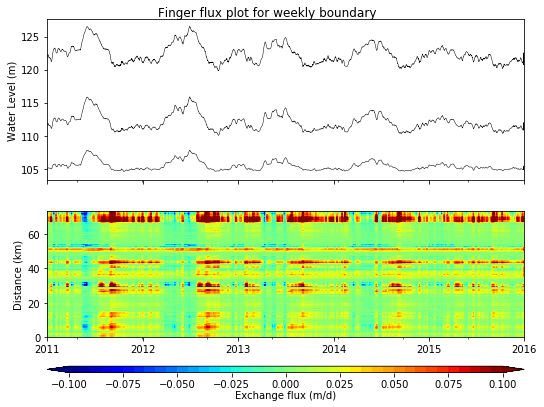

In [155]:
# plot finger flux
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

river_north_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)
river_middle_datum.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
river_south_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)

ax1.set_ylabel('Water Level (m)')
ax1.set_xlabel('')
# ax1.set_title('River stage from upstream to downstream')

plt.xticks(time_ticks, rotation=0, horizontalalignment = "center")
# ax1.set_xticks(time_ticks)

# ax1.set_xlim([time_ticks[0], time_ticks[-1]])


cf1 = ax2.contourf(real_time,
                   0.5 * (mass1_length[1:] + mass1_length[:-1]),
                   -np.transpose(flux_array),
                   cmap=plt.cm.jet,
                   levels=np.arange(-0.1, 0.105, 0.005),
                   extend="both",
                   )
ax2.set_ylabel("")
ax2.set_ylabel("Distance (km)")
# ax2.set_title("Exchange flux of weekly boundary")
ax2.set_xticks(time_ticks)
ax2.set_ylim([0, 73])
ax2.set_xlim([time_ticks[0], time_ticks[-1]])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=0.4, pack_start=True)
fig.add_axes(cax)
cb1 = fig.colorbar(cf1, cax=cax, orientation="horizontal")

# cb1 = plt.colorbar(cf1, extend="both", orientation = "horizontal", pad = 0.2)
cb1.ax.set_xlabel("Exchange flux (m/d)", labelpad=0.3)

fig.suptitle("Finger flux plot for weekly boundary", fontsize = 12)
fig.tight_layout()
fig.set_size_inches(8, 6)

In [156]:
fig.savefig(fig_finger_flux_1w, dpi=300, transparent=False)
plt.close(fig)

## plot finger flux- 6h bc

In [25]:
# read mass balance data
mass_file_2 = open(glob.glob(fname_mass_dat_2)[0], "r")
mass_data_2 = mass_file_2.readlines()
mass_header = mass_data_2[0].replace('"', '').split(",")
mass_header = list(filter(None, mass_header))
mass_data_2 = [x.split(" ") for x in mass_data_2[1:]]
mass_data_2 = [list(filter(None, x)) for x in mass_data_2]
mass_data_2 = np.asarray(mass_data_2).astype(float)

In [32]:
# find columns of desired mass1 colmns
# e.g River_40 Water Mass [kg]
mass_index = [i for i, s in enumerate(mass_header) if (
    "River" in s and "Water" in s and "kg]" in s)]
# e.g River_40 Water Mass [kg/h]
flux_index = [i for i, s in enumerate(mass_header) if (
    "River" in s and "Water" in s and "kg/h" in s)]


In [30]:
# plot fingerprint plots
simu_time = mass_data_2[:, 0]
real_time_2 = batch_delta_to_time(
    date_origin, simu_time, "%Y-%m-%d %H:%M:%S", "hours")
real_time_2 = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in real_time_2]
plot_time = [
    "2011-01-01 00:00:00",
    "2016-01-01 00:00:00"]
plot_time = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in plot_time]
time_ticks = [
    "2011-01-01 00:00:00",
    "2012-01-01 00:00:00",
    "2013-01-01 00:00:00",
    "2014-01-01 00:00:00",
    "2015-01-01 00:00:00",
    "2016-01-01 00:00:00"]
time_ticks = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in time_ticks]

In [ ]:
flux_array_2 = mass_data_2[:, flux_index]
flux_array_2 = np.asarray(flux_array_2) / 1000 * 24
for itime in range(len(real_time_2)):
    flux_array_2[itime, :] = flux_array_2[itime, :] / section_area

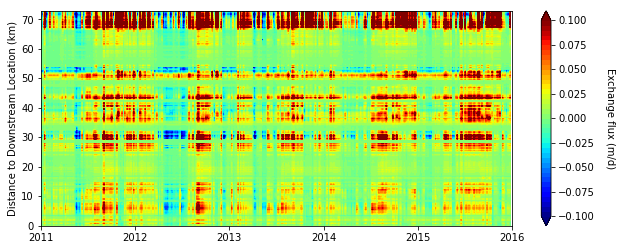

In [49]:
plot finger flux
fig_name = fig_finger_flux
gs = gridspec.GridSpec(1, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0, 0])
cf1 = ax1.contourf(real_time_2,
                   0.5 * (mass1_length[1:] + mass1_length[:-1]),
                   -np.transpose(flux_array_2),
                   cmap=plt.cm.jet,
                   levels=np.arange(-0.1, 0.105, 0.005),
                   extend="both",
                   )
ax1.set_ylabel("")
ax1.set_ylabel("Distance to Downstream Location (km)")
ax1.set_xticks(time_ticks)
ax1.set_ylim([0, 7.3e1])
ax1.set_xlim([time_ticks[0], time_ticks[-1]])
cb1 = plt.colorbar(cf1, extend="both")
cb1.ax.set_ylabel("Exchange flux (m/d)", rotation=270, labelpad=20)
fig.tight_layout()
fig.set_size_inches(10, 3.5)



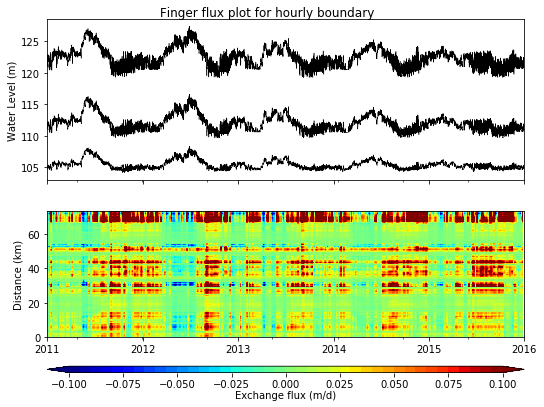

In [124]:
# plot finger flux
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

river_north_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)
river_middle_datum.plot(x='time', y='wl',color= 'black',linewidth = 0.5, ax=ax1, legend=None)
river_south_datum.plot(x='time', y='wl',color= 'black', linewidth = 0.5, ax=ax1, legend=None)

ax1.set_ylabel('Water Level (m)')
ax1.set_xlabel('')
# ax1.set_title('River stage from upstream to downstream')

plt.xticks(time_ticks, rotation=0, horizontalalignment = "center")
# ax1.set_xticks(time_ticks)

# ax1.set_xlim([time_ticks[0], time_ticks[-1]])


cf1 = ax2.contourf(real_time_2,
                   0.5 * (mass1_length[1:] + mass1_length[:-1]),
                   -np.transpose(flux_array_2),
                   cmap=plt.cm.jet,
                   levels=np.arange(-0.1, 0.105, 0.005),
                   extend="both",
                   )
ax2.set_ylabel("")
ax2.set_ylabel("Distance (km)")
# ax2.set_title("Exchange flux of weekly boundary")
ax2.set_xticks(time_ticks)
ax2.set_ylim([0, 73])
ax2.set_xlim([time_ticks[0], time_ticks[-1]])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=0.4, pack_start=True)
fig.add_axes(cax)
cb1 = fig.colorbar(cf1, cax=cax, orientation="horizontal")

# cb1 = plt.colorbar(cf1, extend="both", orientation = "horizontal", pad = 0.2)
cb1.ax.set_xlabel("Exchange flux (m/d)", labelpad=0.3)

fig.suptitle("Finger flux plot for hourly boundary", fontsize = 12)
fig.tight_layout()
fig.set_size_inches(8, 6)

In [125]:
fig.savefig(fig_finger_flux_6h, dpi=300)
plt.close(fig)

## plot net flux difference between 6h and 1w bc

In [36]:
flux_array_1w = flux_array[::20] # 1-w bc simulation has 6h output freq. and 6-h bc has 120 h output freq.
flux_array_6h = flux_array_2

**use abs flux**

In [39]:
flux_array_diff = (np.abs(flux_array_6h) - np.abs(flux_array_1w))/np.abs(flux_array_1w)*100

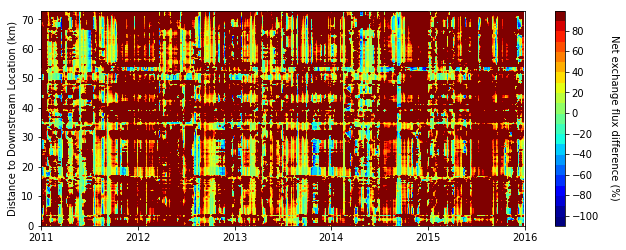

In [162]:
# for itime in range(len(real_time_2)):
#     flux_array_2[itime, :] = flux_array_2[itime, :] / section_area

# plot finger flux
# fig_name = fig_finger_flux
gs = gridspec.GridSpec(1, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0, 0])
cf1 = ax1.contourf(real_time_2,
                   0.5 * (mass1_length[1:] + mass1_length[:-1]),
                   np.transpose(flux_array_diff),
                   cmap=plt.cm.jet,
                   levels=np.arange(-100, 100, 10),
                   extend="both",
                   vmin = -100, vmax = 100,
                   )
ax1.set_ylabel("")
ax1.set_ylabel("Distance to Downstream Location (km)")
ax1.set_xticks(time_ticks)
ax1.set_ylim([0, 73])
ax1.set_xlim([time_ticks[0], time_ticks[-1]])
cb1 = plt.colorbar(cf1, extend="both", extendrect = True)
cb1.ax.set_ylabel("Net exchange flux difference (%)", rotation=270, labelpad=20)

fig.tight_layout()
fig.set_size_inches(10, 3.5)

In [165]:
fname = fig_finger_flux_diff + 'abs_flux_diff_colorbar2.png'
fig.savefig(fname, dpi=300)
plt.close(fig)

**use original flux**

In [128]:
flux_array_diff_sign = (flux_array_6h - flux_array_1w)/flux_array_1w*100

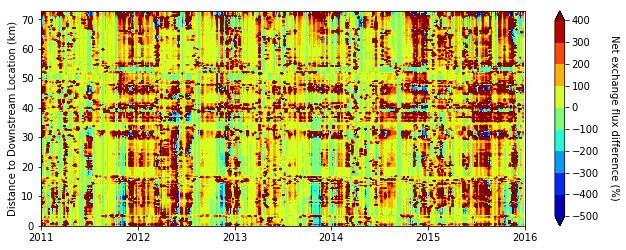

In [132]:
gs = gridspec.GridSpec(1, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0, 0])
cf1 = ax1.contourf(real_time_2,
                   0.5 * (mass1_length[1:] + mass1_length[:-1]),
                   np.transpose(flux_array_diff_sign),
                   cmap=plt.cm.jet,
                   levels=np.arange(-500, 500, 100),
                   extend="both",
                   )
ax1.set_ylabel("")
ax1.set_ylabel("Distance to Downstream Location (km)")
ax1.set_xticks(time_ticks)
ax1.set_ylim([0, 73])
ax1.set_xlim([time_ticks[0], time_ticks[-1]])
cb1 = plt.colorbar(cf1, extend="both")
cb1.ax.set_ylabel("Net exchange flux difference (%)", rotation=270, labelpad=20)
fig.tight_layout()
fig.set_size_inches(10, 3.5)

In [135]:
fig.savefig(fig_finger_flux_diff, dpi=300)
plt.close(fig)

**use 0, 1 represent flux**

In [147]:
flux_ind_6h = [0 if iflux <0 else 1 for iflux in flux_array_6h.flatten()]
flux_ind_1w = [0 if iflux <0 else 1 for iflux in flux_array_1w.flatten()]
flux_ind_6h = np.asarray(flux_ind_6h).reshape(flux_array_6h.shape[0], flux_array_6h.shape[1])
flux_ind_1w = np.asarray(flux_ind_1w).reshape(flux_array_1w.shape[0], flux_array_1w.shape[1])    

In [148]:
flux_array_diff_num = flux_ind_6h - flux_ind_1w

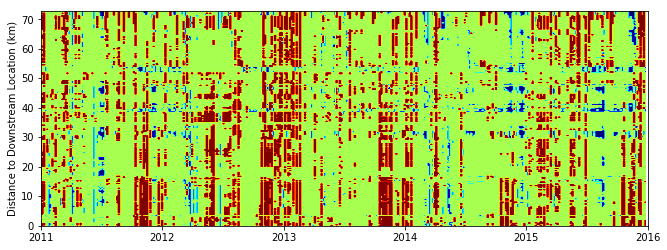

In [167]:
gs = gridspec.GridSpec(1, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[0, 0])
cf1 = ax1.contourf(real_time_2,
                   0.5 * (mass1_length[1:] + mass1_length[:-1]),
                   np.transpose(flux_array_diff_num),
                   cmap=plt.cm.jet,
                   levels=np.arange(-1, 1, 0.1),
                   extend="both",
                   )
ax1.set_ylabel("")
ax1.set_ylabel("Distance to Downstream Location (km)")
ax1.set_xticks(time_ticks)
ax1.set_ylim([0, 73])
ax1.set_xlim([time_ticks[0], time_ticks[-1]])
# cb1 = plt.colorbar(cf1, extend="both")
# cb1.ax.set_ylabel("Net exchange flux difference", rotation=270, labelpad=20)
fig.tight_layout()
fig.set_size_inches(10, 3.5)

In [169]:
fname = fig_finger_flux_diff + 'finger_flux_diff_1_0.png'
fig.savefig(fname, dpi=300)
plt.close(fig)

## plot histgram

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


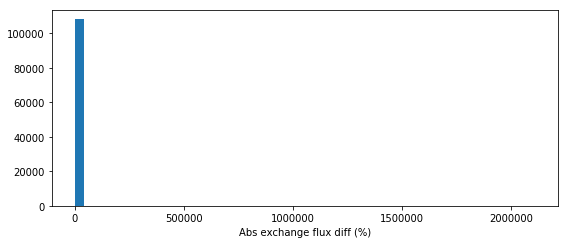

In [183]:
n_bins = 50

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(flux_array_diff.flatten(), bins=n_bins)
# axs[1].hist(-flux_array_1w, bins=n_bins)

# axs.set_title('6h-river bc')
# axs[1].set_title('1w-river bc')
axs.set_xlabel('Abs exchange flux diff (%)')
# axs[1].set_xlabel('Exchange flux (m/d)')
# axs.set_xlim([-500, 500])
# axs[1].set_xlim([-0.4, 0.4])


fig.set_size_inches(8, 3.5)

In [176]:
fname = fig_finger_flux_diff + 'hist_num.png'
fig.savefig(fname, dpi=300)
plt.close(fig)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


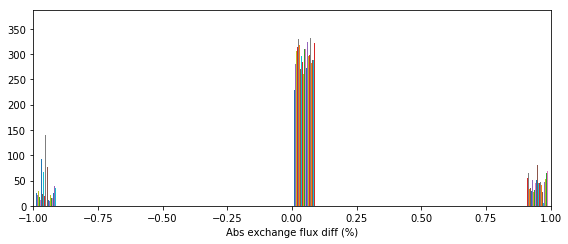

In [182]:
n_bins = 20

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(flux_array_diff_num, bins=n_bins)
# axs[1].hist(-flux_array_1w, bins=n_bins)

# axs.set_title('6h-river bc')
# axs[1].set_title('1w-river bc')
axs.set_xlabel('Abs exchange flux diff (%)')
# axs[1].set_xlabel('Exchange flux (m/d)')
axs.set_xlim([-1, 1])
# axs[1].set_xlim([-0.4, 0.4])


fig.set_size_inches(8, 3.5)

In [176]:
fname = fig_finger_flux_diff + 'hist_num.png'
fig.savefig(fname, dpi=300)
plt.close(fig)

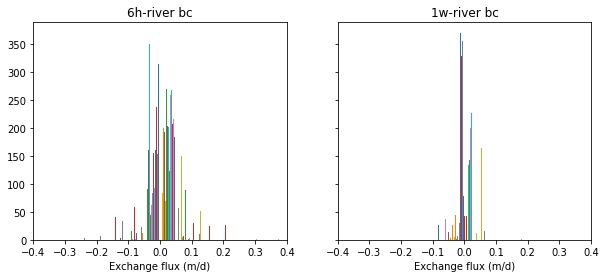

In [171]:
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=False)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(-flux_array_6h, bins=n_bins)
axs[1].hist(-flux_array_1w, bins=n_bins)

axs[0].set_title('6h-river bc')
axs[1].set_title('1w-river bc')
axs[0].set_xlabel('Exchange flux (m/d)')
axs[1].set_xlabel('Exchange flux (m/d)')
axs[0].set_xlim([-0.4, 0.4])
axs[1].set_xlim([-0.4, 0.4])


fig.set_size_inches(10, 4)

In [172]:
fname = fig_finger_flux_diff + 'hist.png'
fig.savefig(fname, dpi=300)
plt.close(fig)

# plot net exchange bar plot

In [53]:
# calculate net mass
n_segment = len(time_ticks) - 1
sum_mass = np.array([0.] * n_segment)
all_mass = np.array([0.] * n_segment)
for i_segment in range(n_segment):
    select_index = []
    for i_index in range(len(real_time)):
        if (real_time[i_index] >= time_ticks[i_segment] and
                real_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    sum_mass[i_segment] = total_mass[select_index[-1]] - \
        total_mass[select_index[0] - 1]
    time_inverval = real_time[select_index[-1]] - real_time[select_index[0] - 1]
    time_scale = 365.25 * 24 * 3600 / time_inverval.total_seconds()
    sum_mass[i_segment] = sum_mass[i_segment] * time_scale / 1000

abs_mass = np.array([0.] * n_segment)
out_mass = np.array([0.] * n_segment)
in_mass = np.array([0.] * n_segment)

In [54]:
# calculate dam discharge
discharge_flow = np.array([0.] * n_segment)
for i_segment in range(n_segment):
    select_index = []
    for i_index in range(len(discharge_time)):
        if (discharge_time[i_index] >= time_ticks[i_segment] and
                discharge_time[i_index] < time_ticks[i_segment + 1]):
            select_index.append(i_index)
    sum_discharge = sum(np.asarray([discharge_value[i]
                                    for i in select_index]).astype(float))
    sum_discharge = sum_discharge * 3600 * 24 * (0.3048**3)
    # print("{:.5E}".format(sum_discharge))
    discharge_flow[i_segment] = sum_discharge

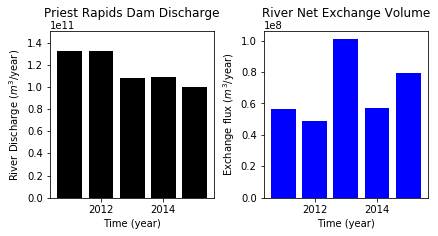

In [56]:
## plot bar plots for net gaining volumn
# plot dam discharge
start_year = 2011
fig_name = fig_net_exchange_bar
gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
ax0 = fig.add_subplot(gs[0, 0])
ax0.bar(start_year + np.arange(n_segment), discharge_flow, color="black")
ax0.set_ylim([0, 1.5e11])
ax0.set_xlabel('Time (year)')
ax0.set_ylabel('River Discharge ($m^3$/year)')
ax0.set_title("Priest Rapids Dam Discharge", y=1.05)

# plot net exchange
ax1 = fig.add_subplot(gs[0, 1])
ax1.bar(start_year + np.arange(n_segment), -sum_mass, color="blue")
#ax1.set_ylim([0, 1e8])
ax1.set_xlabel('Time (year)')
ax1.set_ylabel('Exchange flux ($m^3$/year)')
ax1.set_title("River Net Exchange Volume", y=1.05)
fig.tight_layout()
fig.subplots_adjust(left=0.2,
                    right=0.95,
                    bottom=0.08,
                    top=0.85,
                    wspace=0.30,
                    hspace=0.38
                    )
fig.set_size_inches(7, 3)
# fig.savefig(fig_name, dpi=600, transparent=True)

In [55]:
fig.savefig(fig_name, dpi=600)
plt.close(fig)

In [63]:
# a = -sum_mass
np.savetxt(fname_net_exchange_txt, -sum_mass, fmt = '%.2e')


In [69]:
range(len(real_time[0:1]))

range(0, 1)

# plot flux exchange across riverbed snapshots

0


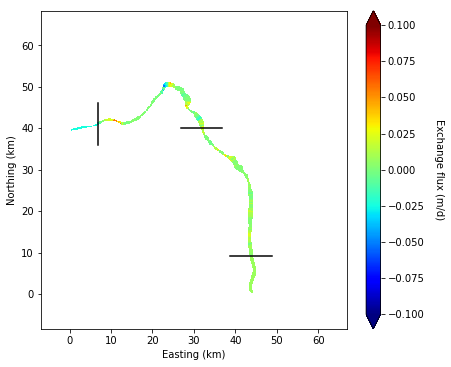

In [74]:
## plot exchange flux accross riverbed snapshots
for itime in range(len(real_time[0:1])):
    print(itime)
    yx_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for isection in range(len(mass1_sections)):
        # need minus 1 as python index started with 0
        cell_ids = list(material_file["Regions"]
                        [mass1_sections[isection]]['Cell Ids'])
        cell_ids = (np.asarray(cell_ids) - 1).astype(int)
        xy_cell_index = [grids[i, 0:2] for i in cell_ids]
        xy_cell_index = np.unique(xy_cell_index, axis=0)
        for iindex in range(len(xy_cell_index)):
            yx_flux[xy_cell_index[iindex][1],
                    xy_cell_index[iindex][0]] = flux_array[itime, isection]
    fig_name = fig_flux_snapshot + str(real_time[itime]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(line1_x, line1_y, "black")
    ax1.plot(line2_x, line2_y, "black")
    ax1.plot(line3_x, line3_y, "black")
    cf1 = ax1.imshow(-yx_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.set_xlabel("Easting (km)")
    ax1.set_ylabel("Northing (km)")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    cb1 = plt.colorbar(cf1, extend="both")
    cb1.ax.set_ylabel("Exchange flux (m/d)", rotation=270, labelpad=20)
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
#     fig.savefig(fig_name, dpi=600)
#     plt.close(fig)    

In [75]:
    fig.savefig(fig_name, dpi=600)
    plt.close(fig)

## plot flux exchange across riverbed snapshots for _north block_

2010-12-07 00:00:00


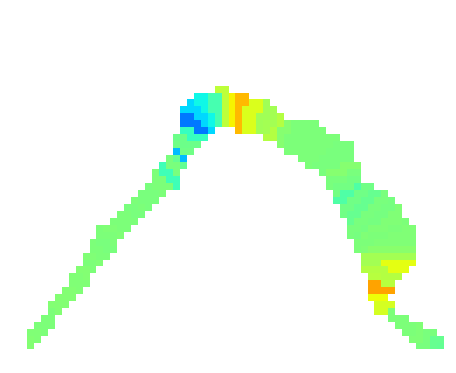

In [80]:
for itime in range(len(real_time[0:1])):
    print(real_time[itime])
    yx_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for isection in range(len(mass1_sections)):
        # need minus 1 as python index started with 0
        cell_ids = list(material_file["Regions"]
                        [mass1_sections[isection]]['Cell Ids'])
        cell_ids = (np.asarray(cell_ids) - 1).astype(int)
        xy_cell_index = [grids[i, 0:2] for i in cell_ids]
        xy_cell_index = np.unique(xy_cell_index, axis=0)
        for iindex in range(len(xy_cell_index)):
            yx_flux[xy_cell_index[iindex][1],
                    xy_cell_index[iindex][0]] = flux_array[itime, isection]
    fig_name = fig_block_north_flux_snapshot + str(real_time[itime]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    cf1 = ax1.imshow(-yx_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.axis("off")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim(block_north_x)
    ax1.set_ylim(block_north_y)
    # ax1.set_xlabel("Easting (km)")
    # ax1.set_ylabel("Northing (km)")
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
#     fig.savefig(fig_name, dpi=600)
#     plt.close(fig)

In [81]:
    fig.savefig(fig_name, dpi=600)
    plt.close(fig)

## plot flux exchange across riverbed snapshots for _middle block_

2010-12-07 00:00:00


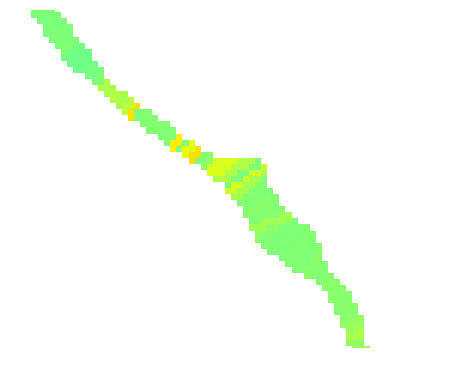

In [82]:
for itime in range(len(real_time[0:1])):
    print(real_time[itime])
    yx_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for isection in range(len(mass1_sections)):
        # need minus 1 as python index started with 0
        cell_ids = list(material_file["Regions"]
                        [mass1_sections[isection]]['Cell Ids'])
        cell_ids = (np.asarray(cell_ids) - 1).astype(int)
        xy_cell_index = [grids[i, 0:2] for i in cell_ids]
        xy_cell_index = np.unique(xy_cell_index, axis=0)
        for iindex in range(len(xy_cell_index)):
            yx_flux[xy_cell_index[iindex][1],
                    xy_cell_index[iindex][0]] = flux_array[itime, isection]
    fig_name = fig_block_middle_flux_snapshot + str(real_time[itime]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    cf1 = ax1.imshow(-yx_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.axis("off")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim(block_middle_x)
    ax1.set_ylim(block_middle_y)
    # ax1.set_xlabel("Easting (km)")
    # ax1.set_ylabel("Northing (km)")
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
#     fig.savefig(fig_name, dpi=600)
#     plt.close(fig)

In [83]:
    fig.savefig(fig_name, dpi=600)
    plt.close(fig)

## plot flux exchange across riverbed snapshots for _south block_

2010-12-07 00:00:00


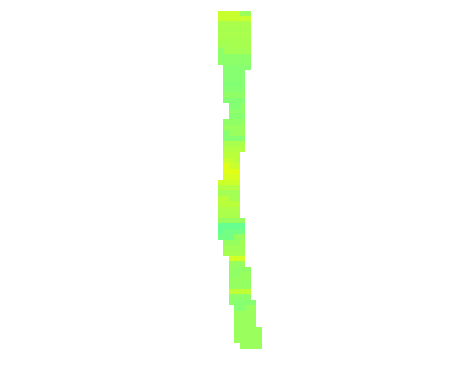

In [84]:
for itime in range(len(real_time[0:1])):
    print(real_time[itime])
    yx_flux = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    for isection in range(len(mass1_sections)):
        # need minus 1 as python index started with 0
        cell_ids = list(material_file["Regions"]
                        [mass1_sections[isection]]['Cell Ids'])
        cell_ids = (np.asarray(cell_ids) - 1).astype(int)
        xy_cell_index = [grids[i, 0:2] for i in cell_ids]
        xy_cell_index = np.unique(xy_cell_index, axis=0)
        for iindex in range(len(xy_cell_index)):
            yx_flux[xy_cell_index[iindex][1],
                    xy_cell_index[iindex][0]] = flux_array[itime, isection]
    fig_name = fig_block_south_flux_snapshot + str(real_time[itime]) + ".png"
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    cf1 = ax1.imshow(-yx_flux,
                     cmap=plt.cm.jet,
                     origin="lower",
                     vmin=-0.1,
                     vmax=0.1,
                     extent=[(x[0] - 0.5 * dx[0]) / 1000,
                             (x[-1] + 0.5 * dx[0]) / 1000,
                             (y[0] - 0.5 * dy[0]) / 1000,
                             (y[-1] + 0.5 * dy[0]) / 1000]
                     )
    ax1.axis("off")
    ax1.set_aspect("equal", "datalim")
    ax1.set_xlim(block_south_x)
    ax1.set_ylim(block_south_y)
    # ax1.set_xlabel("Easting (km)")
    # ax1.set_ylabel("Northing (km)")
    fig.tight_layout()
    fig.set_size_inches(6.5, 5.5)
#     fig.savefig(fig_name, dpi=600)
#     plt.close(fig)

In [85]:
    fig.savefig(fig_name, dpi=600)
    plt.close(fig)